In [1]:
# Cell 1: Installer les dépendances
!pip install optuna keras-tuner keras-tcn tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
# Cell 2: Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten,
    GRU, SimpleRNN, Dense, Dropout,
    MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.pruners import MedianPruner
import keras_tuner as kt
from tcn import TCN
import matplotlib.pyplot as plt


2025-05-05 15:23:26.902620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746458607.076075      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746458607.125906      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Cell 3: Chargement et nettoyage des données
file_path = '/kaggle/input/dataset-ts/Padded Data TS Morocco.csv'
df = pd.read_csv(file_path)
# date → index
df.rename(columns={df.columns[0]:'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
# nettoyage numérique
num_cols = df.columns
df[num_cols] = df[num_cols].replace({' ': '', '\xa0': ''}, regex=True).astype(float)
df.ffill(inplace=True); df.bfill(inplace=True)


In [4]:
# Cell 4: Feature engineering basique
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)
df['dow_sin']   = np.sin(2*np.pi*df.index.dayofweek/7)
df['dow_cos']   = np.cos(2*np.pi*df.index.dayofweek/7)


In [5]:
# Cell 5: Split chronologique train / val / test
n = len(df)
train_end = int(n*0.7)
val_end   = int(n*0.85)
train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]


In [6]:
# Cell 6: Scaling (fit sur train uniquement)
scaler = MinMaxScaler().fit(train_df)


In [7]:
# Cell 7: Création des séquences temporelles
def make_sequences(df_):
    arr = scaler.transform(df_)
    X, y = [], []
    SEQ = 30
    for i in range(len(arr)-SEQ):
        X.append(arr[i:i+SEQ])
        y.append(arr[i+SEQ,:len(num_cols)])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_df)
X_val,   y_val   = make_sequences(pd.concat([train_df.iloc[-30:], val_df]))
X_test,  y_test  = make_sequences(pd.concat([val_df.iloc[-30:], test_df]))
n_features = X_train.shape[2]


In [8]:
# Cell 8: Walk-Forward CV utilitaire
def walk_forward_cv(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(X):
        yield X[tr], y[tr], X[te], y[te]


In [9]:
# Cell 9: Définition des build_functions pour les 7 modèles
def build_lstm(trial):
    u   = trial.suggest_int("units", 32,256)
    d   = trial.suggest_float("dropout",0,0.5)
    L   = trial.suggest_int("n_layers",1,3)
    m   = Sequential([Input((30,n_features))])
    for i in range(L):
        rs = i< L-1
        m.add(LSTM(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols)))
    m.compile("adam","mse"); return m

def build_bilstm(trial):
    u   = trial.suggest_int("units",32,256)
    d   = trial.suggest_float("dropout",0,0.5)
    L   = trial.suggest_int("n_layers",1,3)
    m   = Sequential([Input((30,n_features))])
    for i in range(L):
        rs = i< L-1
        m.add(Bidirectional(LSTM(u,return_sequences=rs)))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols)))
    m.compile("adam","mse"); return m

def build_lstm_cnn(trial):
    lu  = trial.suggest_int("lstm_units",32,256)
    cf  = trial.suggest_int("cnn_filters",16,128)
    ks  = trial.suggest_int("kernel_size",2,5)
    d   = trial.suggest_float("dropout",0,0.5)
    inp=Input((30,n_features))
    x = LSTM(lu,return_sequences=True)(inp)
    x = Conv1D(cf,ks,activation="relu")(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x); x = Dropout(d)(x)
    out= Dense(len(num_cols))(x)
    m=Model(inp,out); m.compile("adam","mse"); return m

def build_gru(trial):
    u=trial.suggest_int("units",32,256)
    d=trial.suggest_float("dropout",0,0.5)
    L=trial.suggest_int("n_layers",1,3)
    m=Sequential([Input((30,n_features))])
    for i in range(L):
        rs=i< L-1
        m.add(GRU(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols))); m.compile("adam","mse"); return m

def build_rnn(trial):
    u=trial.suggest_int("units",32,256)
    d=trial.suggest_float("dropout",0,0.5)
    L=trial.suggest_int("n_layers",1,3)
    m=Sequential([Input((30,n_features))])
    for i in range(L):
        rs=i< L-1
        m.add(SimpleRNN(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols))); m.compile("adam","mse"); return m

def build_tcn(trial):
    f=trial.suggest_int("filters",16,128)
    ks=trial.suggest_int("kernel_size",2,5)
    d=trial.suggest_float("dropout",0,0.5)
    inp=Input((30,n_features))
    x = TCN(nb_filters=f,kernel_size=ks,dilations=[1,2,4],dropout_rate=d)(inp)
    out= Dense(len(num_cols))(x)
    m=Model(inp,out); m.compile("adam","mse"); return m

# Cell 9 (modifiée) : Définition des build_functions pour les 7 modèles,
# avec build_transformer corrigé

def build_transformer(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(30, n_features))
    # 1) Self-attention
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)

    # 2) Residual + Norm (attention)
    x1 = Add()([inp, attn])
    x1 = LayerNormalization(epsilon=1e-6)(x1)

    # 3) Feed-forward on last dim d_model
    ffn = Dense(ff_dim, activation="relu")(x1)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(d_model)(ffn)  # <-- on ramène à d_model, pas à len(num_cols)

    # 4) Residual + Norm (FFN)
    x2 = Add()([x1, ffn])
    x2 = LayerNormalization(epsilon=1e-6)(x2)

    # 5) Flatten & projection finale vers len(num_cols)
    flat = Flatten()(x2)
    out  = Dense(len(num_cols), activation="linear")(flat)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model



In [10]:
# Cell 10a: Coarse tuning Optuna pour LSTM

import numpy as np
from sklearn.metrics import mean_squared_error

def objective_lstm(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_lstm(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_lstm.optimize(objective_lstm, n_trials=20)
best_params_lstm = study_lstm.best_trial.params
print("Best LSTM params:", best_params_lstm)


[I 2025-05-05 15:23:58,418] A new study created in memory with name: no-name-b39d9c2a-91cf-4c4e-9505-3eceddda569c
I0000 00:00:1746458639.346298      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746458642.916086     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-05 15:24:10,024] Trial 0 finished with value: 0.05855351677712218 and parameters: {'units': 42, 'dropout': 0.48118767765382875, 'n_layers': 1}. Best is trial 0 with value: 0.05855351677712218.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


[I 2025-05-05 15:24:26,070] Trial 1 finished with value: 0.03411714784876649 and parameters: {'units': 238, 'dropout': 0.2610182692814829, 'n_layers': 3}. Best is trial 1 with value: 0.03411714784876649.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


[I 2025-05-05 15:24:42,392] Trial 2 finished with value: 0.035408539120101196 and parameters: {'units': 189, 'dropout': 0.10512458791670659, 'n_layers': 3}. Best is trial 1 with value: 0.03411714784876649.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-05 15:24:49,605] Trial 3 finished with value: 0.03896773336020678 and parameters: {'units': 113, 'dropout': 0.4794462885959593, 'n_layers': 1}. Best is trial 1 with value: 0.03411714784876649.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


[I 2025-05-05 15:25:05,340] Trial 4 finished with value: 0.03377809336827713 and parameters: {'units': 214, 'dropout': 0.1696522052145254, 'n_layers': 3}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-05 15:25:12,678] Trial 5 finished with value: 0.03381028229640141 and parameters: {'units': 214, 'dropout': 0.4247186057039071, 'n_layers': 1}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


[I 2025-05-05 15:25:28,942] Trial 6 finished with value: 0.036664686690975196 and parameters: {'units': 117, 'dropout': 0.3185441689783211, 'n_layers': 3}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


[I 2025-05-05 15:25:34,322] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-05-05 15:25:36,535] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


[I 2025-05-05 15:25:52,542] Trial 9 finished with value: 0.03521842617665825 and parameters: {'units': 198, 'dropout': 0.4433912229852163, 'n_layers': 3}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


[I 2025-05-05 15:25:56,825] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


[I 2025-05-05 15:26:08,276] Trial 11 finished with value: 0.03458543181229464 and parameters: {'units': 188, 'dropout': 0.18090714427286267, 'n_layers': 2}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-05-05 15:26:12,605] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-05-05 15:26:24,496] Trial 13 finished with value: 0.03478849482884875 and parameters: {'units': 150, 'dropout': 0.3152733664636953, 'n_layers': 2}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


[I 2025-05-05 15:26:27,669] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-05 15:26:40,022] Trial 15 finished with value: 0.03392704302562966 and parameters: {'units': 226, 'dropout': 0.3476163669580833, 'n_layers': 2}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-05 15:26:47,049] Trial 16 finished with value: 0.03445276879000404 and parameters: {'units': 168, 'dropout': 0.21547364070807334, 'n_layers': 1}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-05 15:26:59,979] Trial 17 finished with value: 0.033812892503136786 and parameters: {'units': 252, 'dropout': 0.13057466009801924, 'n_layers': 2}. Best is trial 4 with value: 0.03377809336827713.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


[I 2025-05-05 15:27:04,967] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-05 15:27:07,231] Trial 19 pruned. 


Best LSTM params: {'units': 214, 'dropout': 0.1696522052145254, 'n_layers': 3}


In [11]:
# Cell 10b: Coarse tuning Optuna pour BiLSTM

def objective_bilstm(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_bilstm(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_bilstm = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_bilstm.optimize(objective_bilstm, n_trials=20)
best_params_bilstm = study_bilstm.best_trial.params
print("Best BiLSTM params:", best_params_bilstm)


[I 2025-05-05 15:28:17,865] A new study created in memory with name: no-name-9d4447b3-59e7-4cc8-bc44-23cc32dee8bd


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step


[I 2025-05-05 15:28:39,097] Trial 0 finished with value: 0.034069073640653556 and parameters: {'units': 132, 'dropout': 0.4383424809977717, 'n_layers': 2}. Best is trial 0 with value: 0.034069073640653556.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2025-05-05 15:28:50,718] Trial 1 finished with value: 0.03469105736677449 and parameters: {'units': 238, 'dropout': 0.18742177464029358, 'n_layers': 1}. Best is trial 0 with value: 0.034069073640653556.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 879ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step


[I 2025-05-05 15:29:19,054] Trial 2 finished with value: 0.03207889361085445 and parameters: {'units': 196, 'dropout': 0.2355632419604245, 'n_layers': 3}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step


[I 2025-05-05 15:29:40,091] Trial 3 finished with value: 0.033059036349068045 and parameters: {'units': 256, 'dropout': 0.4630537504344822, 'n_layers': 2}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


[I 2025-05-05 15:30:01,028] Trial 4 finished with value: 0.03299314555687969 and parameters: {'units': 228, 'dropout': 0.16442163767819667, 'n_layers': 2}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 974ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step


[I 2025-05-05 15:30:29,548] Trial 5 finished with value: 0.03545737756797456 and parameters: {'units': 65, 'dropout': 0.34448466268820865, 'n_layers': 3}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


[I 2025-05-05 15:30:49,454] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step


[I 2025-05-05 15:31:03,116] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-05-05 15:31:13,825] Trial 8 finished with value: 0.03345893663150957 and parameters: {'units': 222, 'dropout': 0.11167620617043045, 'n_layers': 1}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


[I 2025-05-05 15:31:22,312] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step


[I 2025-05-05 15:31:41,368] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


[I 2025-05-05 15:31:55,176] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step


[I 2025-05-05 15:32:05,603] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


[I 2025-05-05 15:32:25,906] Trial 13 finished with value: 0.03278057764376644 and parameters: {'units': 207, 'dropout': 0.2517333094416529, 'n_layers': 2}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step


[I 2025-05-05 15:32:36,404] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2025-05-05 15:32:50,517] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step


[I 2025-05-05 15:32:56,674] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step


[I 2025-05-05 15:33:07,237] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2025-05-05 15:33:17,978] Trial 18 finished with value: 0.03476423596171154 and parameters: {'units': 147, 'dropout': 0.38701479089475044, 'n_layers': 1}. Best is trial 2 with value: 0.03207889361085445.


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step


[I 2025-05-05 15:33:26,000] Trial 19 pruned. 


Best BiLSTM params: {'units': 196, 'dropout': 0.2355632419604245, 'n_layers': 3}


In [12]:
# Cell 10c: Coarse tuning Optuna pour LSTM-CNN

def objective_lstm_cnn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_lstm_cnn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm_cnn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_lstm_cnn.optimize(objective_lstm_cnn, n_trials=20)
best_params_lstm_cnn = study_lstm_cnn.best_trial.params
print("Best LSTM-CNN params:", best_params_lstm_cnn)


[I 2025-05-05 15:33:39,687] A new study created in memory with name: no-name-a9540506-bd5c-459a-a2be-33fb9cb7ecd6


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 15:33:48,996] Trial 0 finished with value: 0.034576242936459216 and parameters: {'lstm_units': 179, 'cnn_filters': 117, 'kernel_size': 5, 'dropout': 0.16426463538198322}. Best is trial 0 with value: 0.034576242936459216.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 15:33:57,518] Trial 1 finished with value: 0.03434806167878122 and parameters: {'lstm_units': 206, 'cnn_filters': 123, 'kernel_size': 4, 'dropout': 0.3541933925452644}. Best is trial 1 with value: 0.03434806167878122.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 15:34:07,976] Trial 2 finished with value: 0.0398558925022356 and parameters: {'lstm_units': 235, 'cnn_filters': 26, 'kernel_size': 2, 'dropout': 0.28470870558156797}. Best is trial 1 with value: 0.03434806167878122.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-05 15:34:16,557] Trial 3 finished with value: 0.039032536464817975 and parameters: {'lstm_units': 138, 'cnn_filters': 52, 'kernel_size': 5, 'dropout': 0.4255022915760236}. Best is trial 1 with value: 0.03434806167878122.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


[I 2025-05-05 15:34:27,140] Trial 4 finished with value: 0.04788414601336086 and parameters: {'lstm_units': 190, 'cnn_filters': 21, 'kernel_size': 2, 'dropout': 0.44324798105360236}. Best is trial 1 with value: 0.03434806167878122.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 15:34:35,906] Trial 5 finished with value: 0.034003542195480733 and parameters: {'lstm_units': 87, 'cnn_filters': 88, 'kernel_size': 5, 'dropout': 0.44488319453051683}. Best is trial 5 with value: 0.034003542195480733.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 15:34:38,775] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 15:34:47,387] Trial 7 finished with value: 0.034795746220717357 and parameters: {'lstm_units': 142, 'cnn_filters': 95, 'kernel_size': 3, 'dropout': 0.30989434352508693}. Best is trial 5 with value: 0.034003542195480733.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 15:34:50,240] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 15:35:01,110] Trial 9 finished with value: 0.033851127160898324 and parameters: {'lstm_units': 230, 'cnn_filters': 77, 'kernel_size': 2, 'dropout': 0.14094953573279562}. Best is trial 9 with value: 0.033851127160898324.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 15:35:09,663] Trial 10 finished with value: 0.03321554129184481 and parameters: {'lstm_units': 250, 'cnn_filters': 62, 'kernel_size': 3, 'dropout': 0.041838588218315154}. Best is trial 10 with value: 0.03321554129184481.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 15:35:12,567] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 15:35:15,532] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-05-05 15:35:26,227] Trial 13 finished with value: 0.03372765158981478 and parameters: {'lstm_units': 254, 'cnn_filters': 49, 'kernel_size': 2, 'dropout': 0.10235053117298576}. Best is trial 10 with value: 0.03321554129184481.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 15:35:29,019] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 15:35:31,840] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-05 15:35:34,659] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 15:35:45,314] Trial 17 finished with value: 0.0349443277014302 and parameters: {'lstm_units': 158, 'cnn_filters': 100, 'kernel_size': 3, 'dropout': 0.20764559286103884}. Best is trial 10 with value: 0.03321554129184481.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 15:35:48,288] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 15:35:51,079] Trial 19 pruned. 


Best LSTM-CNN params: {'lstm_units': 250, 'cnn_filters': 62, 'kernel_size': 3, 'dropout': 0.041838588218315154}


In [13]:
# Cell 10d: Coarse tuning Optuna pour GRU

def objective_gru(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_gru(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_gru = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_gru.optimize(objective_gru, n_trials=20)
best_params_gru = study_gru.best_trial.params
print("Best GRU params:", best_params_gru)


[I 2025-05-05 15:37:44,377] A new study created in memory with name: no-name-9f03976e-1d5c-4384-99ab-152dd6ebb6a7


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-05-05 15:37:54,503] Trial 0 finished with value: 0.03756186786774573 and parameters: {'units': 75, 'dropout': 0.4707410743988003, 'n_layers': 2}. Best is trial 0 with value: 0.03756186786774573.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


[I 2025-05-05 15:38:10,747] Trial 1 finished with value: 0.03500713027380579 and parameters: {'units': 134, 'dropout': 0.3990698043411967, 'n_layers': 3}. Best is trial 1 with value: 0.03500713027380579.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-05 15:38:21,017] Trial 2 finished with value: 0.03422081361863082 and parameters: {'units': 84, 'dropout': 0.270945257546264, 'n_layers': 2}. Best is trial 2 with value: 0.03422081361863082.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-05-05 15:38:34,030] Trial 3 finished with value: 0.03459453137776806 and parameters: {'units': 146, 'dropout': 0.2541453031385739, 'n_layers': 2}. Best is trial 2 with value: 0.03422081361863082.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-05 15:38:44,730] Trial 4 finished with value: 0.03303529803062807 and parameters: {'units': 197, 'dropout': 0.39276782301220503, 'n_layers': 2}. Best is trial 4 with value: 0.03303529803062807.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-05 15:38:48,127] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-05 15:38:52,663] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-05 15:38:56,137] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-05 15:39:09,194] Trial 8 finished with value: 0.03366192011549686 and parameters: {'units': 172, 'dropout': 0.4892760213914178, 'n_layers': 2}. Best is trial 4 with value: 0.03303529803062807.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-05 15:39:23,011] Trial 9 finished with value: 0.03379226817343017 and parameters: {'units': 93, 'dropout': 0.3646165803902881, 'n_layers': 3}. Best is trial 4 with value: 0.03303529803062807.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 15:39:27,842] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-05 15:39:30,125] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2025-05-05 15:39:32,447] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-05 15:39:42,950] Trial 13 finished with value: 0.03303193243165872 and parameters: {'units': 196, 'dropout': 0.42037583947611457, 'n_layers': 2}. Best is trial 13 with value: 0.03303193243165872.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 15:39:49,592] Trial 14 finished with value: 0.03264446186682635 and parameters: {'units': 233, 'dropout': 0.14902962671270062, 'n_layers': 1}. Best is trial 14 with value: 0.03264446186682635.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-05 15:39:51,780] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-05 15:39:53,972] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-05-05 15:39:58,806] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-05-05 15:40:03,514] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-05 15:40:05,755] Trial 19 pruned. 


Best GRU params: {'units': 233, 'dropout': 0.14902962671270062, 'n_layers': 1}


In [14]:
# Cell 10e: Coarse tuning Optuna pour RNN

def objective_rnn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_rnn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_rnn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_rnn.optimize(objective_rnn, n_trials=20)
best_params_rnn = study_rnn.best_trial.params
print("Best RNN params:", best_params_rnn)


[I 2025-05-05 15:41:37,719] A new study created in memory with name: no-name-19ca103c-f486-4614-b1df-c21f0b3902a6
I0000 00:00:1746459700.666809     100 service.cc:148] XLA service 0x5b1a2310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746459700.667429     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746459702.583166     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


[I 2025-05-05 15:42:02,607] Trial 0 finished with value: 0.13759198047085072 and parameters: {'units': 112, 'dropout': 0.2073283704947983, 'n_layers': 2}. Best is trial 0 with value: 0.13759198047085072.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2025-05-05 15:42:17,323] Trial 1 finished with value: 0.15907141599539634 and parameters: {'units': 56, 'dropout': 0.23301637920981405, 'n_layers': 1}. Best is trial 0 with value: 0.13759198047085072.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-05-05 15:42:54,879] Trial 2 finished with value: 0.14349355791202043 and parameters: {'units': 206, 'dropout': 0.08778164865199217, 'n_layers': 3}. Best is trial 0 with value: 0.13759198047085072.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2025-05-05 15:43:32,450] Trial 3 finished with value: 0.2642200436216804 and parameters: {'units': 161, 'dropout': 0.36614903339852917, 'n_layers': 3}. Best is trial 0 with value: 0.13759198047085072.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-05-05 15:43:47,409] Trial 4 finished with value: 0.0994180034652145 and parameters: {'units': 130, 'dropout': 0.17155673312835484, 'n_layers': 1}. Best is trial 4 with value: 0.0994180034652145.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-05-05 15:43:58,905] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


[I 2025-05-05 15:44:10,601] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


[I 2025-05-05 15:44:22,387] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step


[I 2025-05-05 15:44:37,167] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step


[I 2025-05-05 15:44:48,701] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


[I 2025-05-05 15:45:03,782] Trial 10 finished with value: 0.0737421793661888 and parameters: {'units': 253, 'dropout': 0.13849509412137304, 'n_layers': 1}. Best is trial 10 with value: 0.0737421793661888.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2025-05-05 15:45:18,789] Trial 11 finished with value: 0.0707480262637859 and parameters: {'units': 255, 'dropout': 0.1414633409627145, 'n_layers': 1}. Best is trial 11 with value: 0.0707480262637859.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2025-05-05 15:45:33,429] Trial 12 finished with value: 0.07027067918194822 and parameters: {'units': 253, 'dropout': 0.11668338422616867, 'n_layers': 1}. Best is trial 12 with value: 0.07027067918194822.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 15:45:45,744] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2025-05-05 15:46:00,946] Trial 14 finished with value: 0.0849815007691641 and parameters: {'units': 210, 'dropout': 0.302337906251726, 'n_layers': 1}. Best is trial 12 with value: 0.07027067918194822.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step


[I 2025-05-05 15:46:09,382] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-05-05 15:46:19,333] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2025-05-05 15:46:34,268] Trial 17 finished with value: 0.07060694857106799 and parameters: {'units': 228, 'dropout': 0.13005143323644044, 'n_layers': 1}. Best is trial 12 with value: 0.07027067918194822.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step


[I 2025-05-05 15:46:42,595] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2025-05-05 15:46:52,714] Trial 19 pruned. 


Best RNN params: {'units': 253, 'dropout': 0.11668338422616867, 'n_layers': 1}


In [15]:
# Cell 10f: Coarse tuning Optuna pour TCN

def objective_tcn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_tcn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_tcn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_tcn.optimize(objective_tcn, n_trials=20)
best_params_tcn = study_tcn.best_trial.params
print("Best TCN params:", best_params_tcn)


[I 2025-05-05 15:47:23,174] A new study created in memory with name: no-name-d00211eb-99b3-4c36-8a1d-83bec2a113bb


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-05-05 15:48:09,690] Trial 0 finished with value: 0.1780237879886756 and parameters: {'filters': 110, 'kernel_size': 4, 'dropout': 0.42695221069844375}. Best is trial 0 with value: 0.1780237879886756.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-05-05 15:48:50,487] Trial 1 finished with value: 0.1799793148815588 and parameters: {'filters': 48, 'kernel_size': 4, 'dropout': 0.2076573045262209}. Best is trial 0 with value: 0.1780237879886756.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2025-05-05 15:49:35,933] Trial 2 finished with value: 0.7526615556272441 and parameters: {'filters': 16, 'kernel_size': 5, 'dropout': 0.20112224989256283}. Best is trial 0 with value: 0.1780237879886756.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step


[I 2025-05-05 15:50:16,397] Trial 3 finished with value: 0.3400535372489119 and parameters: {'filters': 53, 'kernel_size': 3, 'dropout': 0.19438167276479978}. Best is trial 0 with value: 0.1780237879886756.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-05-05 15:51:00,931] Trial 4 finished with value: 0.16256864357878 and parameters: {'filters': 84, 'kernel_size': 3, 'dropout': 0.3531150373837333}. Best is trial 4 with value: 0.16256864357878.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-05-05 15:51:28,840] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


[I 2025-05-05 15:51:56,336] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-05-05 15:52:23,492] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-05-05 15:52:41,753] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2025-05-05 15:52:55,815] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-05-05 15:53:23,630] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-05-05 15:54:05,399] Trial 11 finished with value: 0.17918653497855308 and parameters: {'filters': 120, 'kernel_size': 3, 'dropout': 0.3610236291989245}. Best is trial 4 with value: 0.16256864357878.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-05-05 15:54:24,771] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-05-05 15:55:06,759] Trial 13 finished with value: 0.17001854744413838 and parameters: {'filters': 101, 'kernel_size': 3, 'dropout': 0.4587968348523479}. Best is trial 4 with value: 0.16256864357878.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-05-05 15:55:34,332] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-05-05 15:55:48,511] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2025-05-05 15:56:02,831] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-05-05 15:56:21,980] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-05-05 15:56:36,005] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-05-05 15:56:49,988] Trial 19 pruned. 


Best TCN params: {'filters': 84, 'kernel_size': 3, 'dropout': 0.3531150373837333}


In [17]:
# Cell 10g: Coarse tuning Optuna pour Transformer (avec build_transformer corrigé)

import numpy as np
from sklearn.metrics import mean_squared_error

# On redéfinit build_transformer pour assurer des shapes compatibles
def build_transformer(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(30, n_features))
    # Self-attention (sortie reste de dim n_features)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)
    x1   = Add()([inp, attn])
    x1   = LayerNormalization(epsilon=1e-6)(x1)

    # FFN projeté sur n_features pour pouvoir résiduel sur x1
    ffn  = Dense(ff_dim, activation="relu")(x1)
    ffn  = Dropout(dropout)(ffn)
    ffn  = Dense(n_features)(ffn)
    x2   = Add()([x1, ffn])
    x2   = LayerNormalization(epsilon=1e-6)(x2)

    # Flatten + dernière projection
    flat = Flatten()(x2)
    out  = Dense(len(num_cols), activation="linear")(flat)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_transformer(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_transformer(trial)
        m.fit(
            Xt, yt,
            validation_data=(Xv, yv),
            epochs=30, batch_size=32,
            callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
            verbose=0
        )
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_transformer = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_transformer.optimize(objective_transformer, n_trials=20)
best_params_transformer = study_transformer.best_trial.params
print("Best Transformer params:", best_params_transformer)


[I 2025-05-05 15:58:56,130] A new study created in memory with name: no-name-089de8df-42dc-42c5-a3cb-b52cd8f1010a


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 15:59:31,371] Trial 0 finished with value: 0.5558116463813759 and parameters: {'d_model': 101, 'num_heads': 3, 'ff_dim': 79, 'dropout': 0.1200296386353003}. Best is trial 0 with value: 0.5558116463813759.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


[I 2025-05-05 16:00:10,631] Trial 1 finished with value: 0.6094991767995867 and parameters: {'d_model': 68, 'num_heads': 2, 'ff_dim': 118, 'dropout': 0.4707280081410084}. Best is trial 0 with value: 0.5558116463813759.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


[I 2025-05-05 16:00:45,099] Trial 2 finished with value: 0.6428745888932179 and parameters: {'d_model': 48, 'num_heads': 3, 'ff_dim': 83, 'dropout': 0.46133032087876485}. Best is trial 0 with value: 0.5558116463813759.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step


[I 2025-05-05 16:01:20,410] Trial 3 finished with value: 0.5137482224292986 and parameters: {'d_model': 111, 'num_heads': 3, 'ff_dim': 61, 'dropout': 0.4523912312534321}. Best is trial 3 with value: 0.5137482224292986.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-05 16:02:00,959] Trial 4 finished with value: 0.5570985578726982 and parameters: {'d_model': 107, 'num_heads': 3, 'ff_dim': 54, 'dropout': 0.35731147401453184}. Best is trial 3 with value: 0.5137482224292986.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step


[I 2025-05-05 16:02:25,116] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 16:03:00,937] Trial 6 finished with value: 0.4421189680180095 and parameters: {'d_model': 62, 'num_heads': 4, 'ff_dim': 108, 'dropout': 0.17305214767172206}. Best is trial 6 with value: 0.4421189680180095.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


[I 2025-05-05 16:03:23,536] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-05-05 16:03:52,640] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-05-05 16:04:28,638] Trial 9 finished with value: 0.48688740331973773 and parameters: {'d_model': 74, 'num_heads': 3, 'ff_dim': 70, 'dropout': 0.05270612091692006}. Best is trial 6 with value: 0.4421189680180095.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step


[I 2025-05-05 16:05:03,258] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-05-05 16:05:15,540] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-05-05 16:05:57,463] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2025-05-05 16:06:33,471] Trial 13 finished with value: 0.44631248439792914 and parameters: {'d_model': 86, 'num_heads': 4, 'ff_dim': 69, 'dropout': 0.09441398755121388}. Best is trial 6 with value: 0.4421189680180095.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-05-05 16:06:46,146] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-05-05 16:06:58,447] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 16:07:10,270] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-05-05 16:07:22,529] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


[I 2025-05-05 16:07:45,679] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 16:08:27,213] Trial 19 pruned. 


Best Transformer params: {'d_model': 62, 'num_heads': 4, 'ff_dim': 108, 'dropout': 0.17305214767172206}


In [21]:
# Cell 11: Entraînement final & sélection du meilleur modèle par indicateur

# (Re)définition du mapping nom → fonction de construction
builders = {
    'LSTM':        build_lstm,
    'BiLSTM':      build_bilstm,
    'LSTM-CNN':    build_lstm_cnn,
    'GRU':         build_gru,
    'RNN':         build_rnn,
    'TCN':         build_tcn,
    'Transformer': build_transformer
}

# best_params_<model> doivent déjà exister de vos cellules 10a–10g
best_params = {
    'LSTM':        best_params_lstm,
    'BiLSTM':      best_params_bilstm,
    'LSTM-CNN':    best_params_lstm_cnn,
    'GRU':         best_params_gru,
    'RNN':         best_params_rnn,
    'TCN':         best_params_tcn,
    'Transformer': best_params_transformer
}

# 1) Réentraîner chaque modèle sur train+val
final_models = {}
for name, build_fn in builders.items():
    trial = optuna.trial.FixedTrial(best_params[name])
    m = build_fn(trial)
    m.fit(
        np.vstack([X_train, X_val]),
        np.vstack([y_train, y_val]),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
        verbose=0
    )
    final_models[name] = m

# 2) Choisir, pour chaque indicateur, le modèle qui minimise la MSE sur le test
best_model_per_col = {}
for i, col in enumerate(num_cols):
    best_model_per_col[col] = min(
        final_models.keys(),
        key=lambda nm: mean_squared_error(
            y_test[:, i],
            final_models[nm].predict(X_test)[:, i]
        )
    )

print("Meilleur modèle par indicateur :")
for col, mdl in best_model_per_col.items():
    print(f"  {col:20s}: {mdl}")


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━

In [23]:
# Cell 12: Calcul des métriques en excluant les zéros (par indicateur)

# Récupérer les paramètres de scaling pour les cibles
target_dims = len(num_cols)
mins   = scaler.min_[:target_dims]
scales = scaler.scale_[:target_dims]

# Inversion manuelle du scaling sur y_test et preds
y_true = (y_test - mins) / scales

print("Métriques (excluant 0) par indicateur :")
for i, col in enumerate(num_cols):
    m = final_models[best_model_per_col[col]]
    preds_scaled = m.predict(X_test)[:, i]
    preds = (preds_scaled - mins[i]) / scales[i]

    mask = y_true[:, i] != 0
    mse = mean_squared_error(y_true[mask, i], preds[mask])
    mae = mean_absolute_error (y_true[mask, i], preds[mask])
    print(f"{col:20s} → MSE: {mse:.4f}, MAE: {mae:.4f}")


Métriques (excluant 0) par indicateur :
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
IDE(USD)             → MSE: 522644765959024064.0000, MAE: 633449274.9259
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
REER(2010 = 100)     → MSE: 377.9903, MAE: 18.9110
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
brent_oil_prices(USD/barrel) → MSE: 442.1896, MAE: 15.3507
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
crude_oil_prices(USD/barrel) → MSE: 93.7103, MAE: 7.3724
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
daily_natural_gas_prices(USD/MMBtu) → MSE: 1.6588, MAE: 1.0193
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
annual_gold_prices(USD/oz) → MSE: 15169.2815, MAE: 108.0613
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
wheat_production (Million Bushels) → MSE: 143425.1720, MAE: 289.3922
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
InterTourismeReceipts(usd) → MSE: 3043448922873032704.0000, MAE: 1505142992.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Inflation, prix à la consommation (% annuel) → MSE: 5.7829, MAE: 1.6754
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


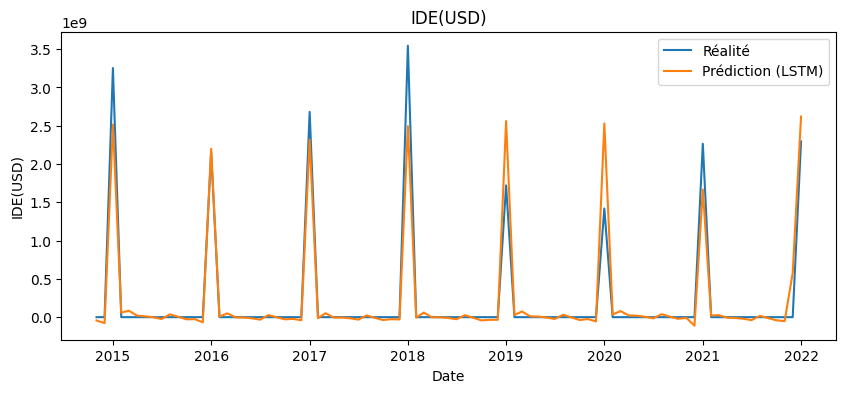

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


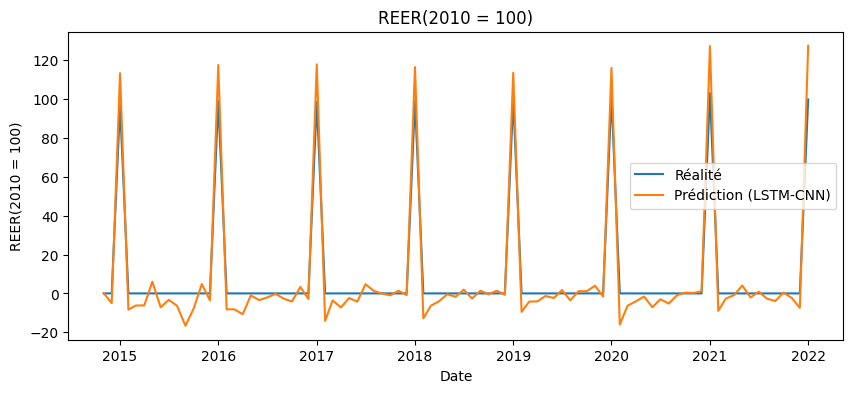

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


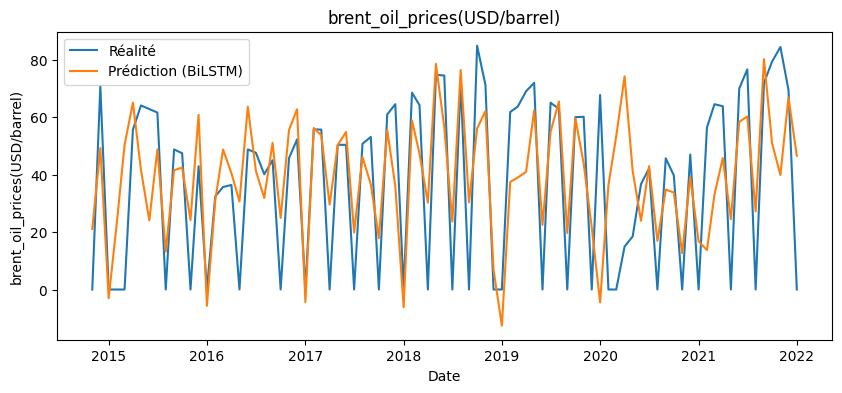

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


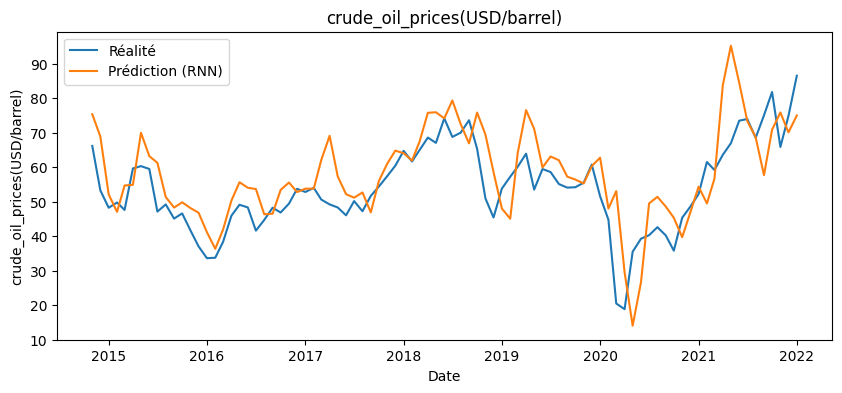

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


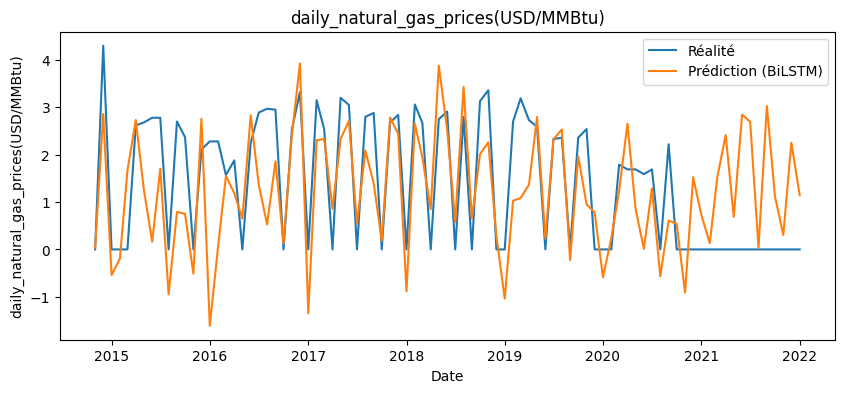

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


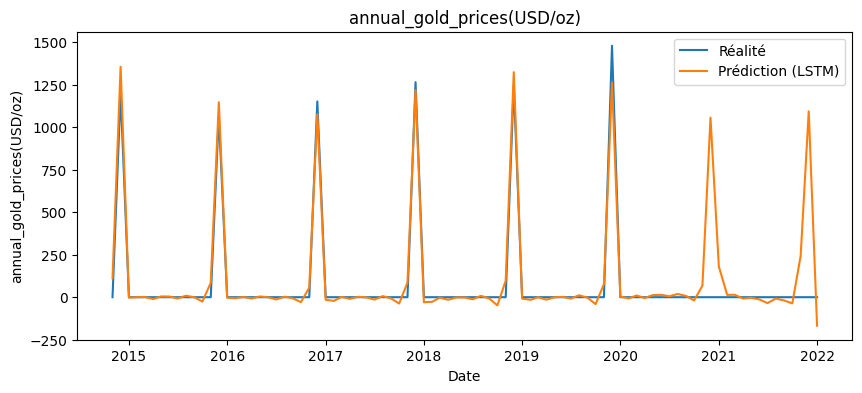

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


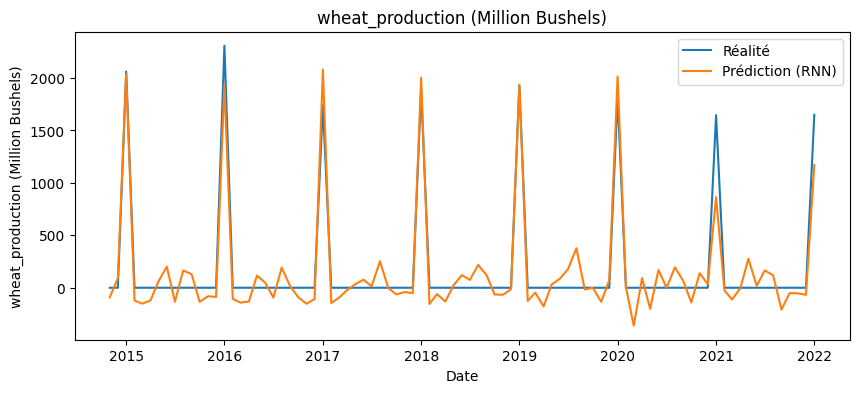

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


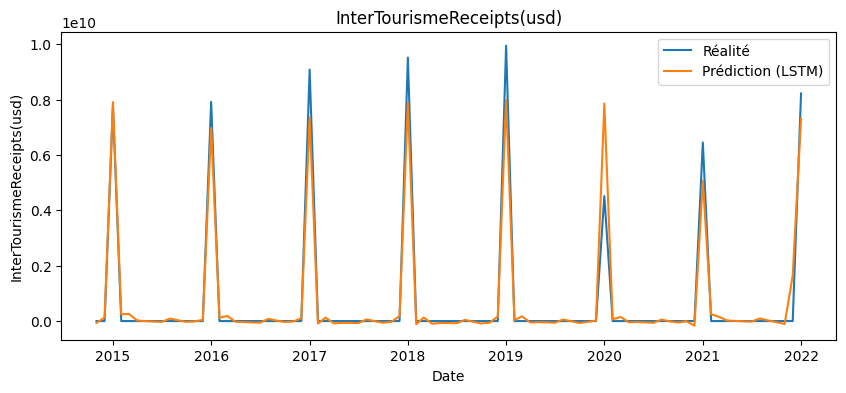

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


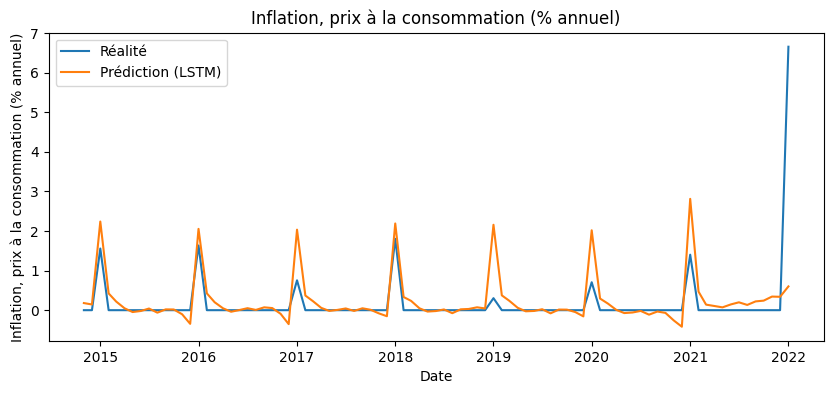

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


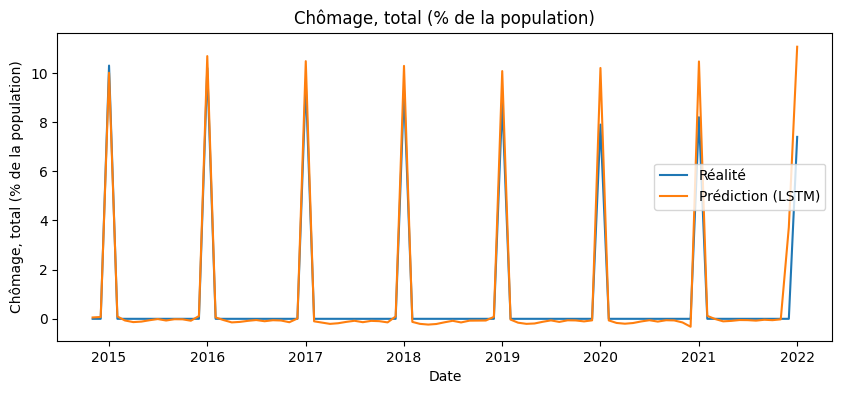

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


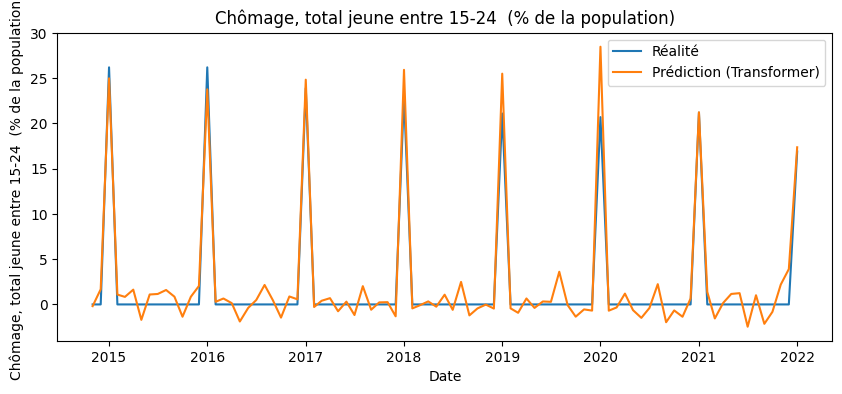

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


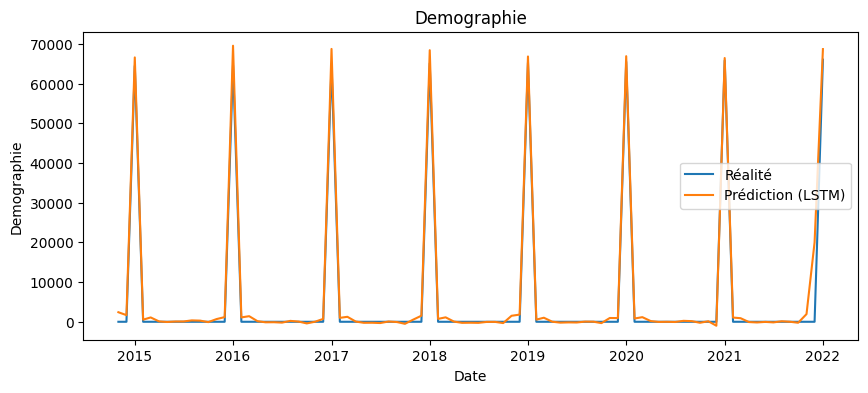

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


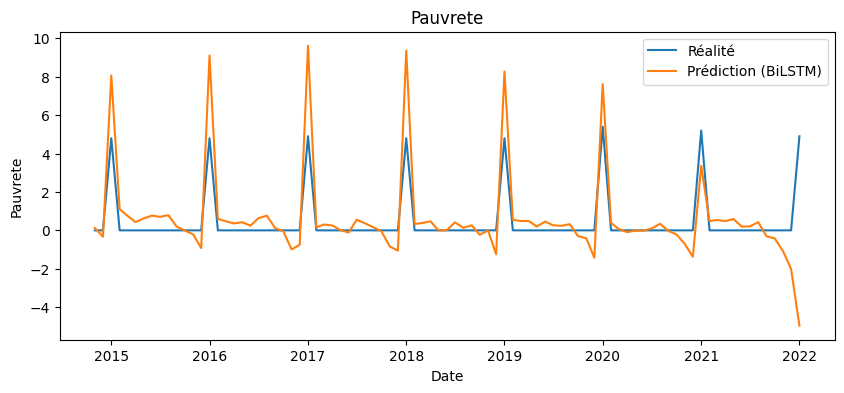

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


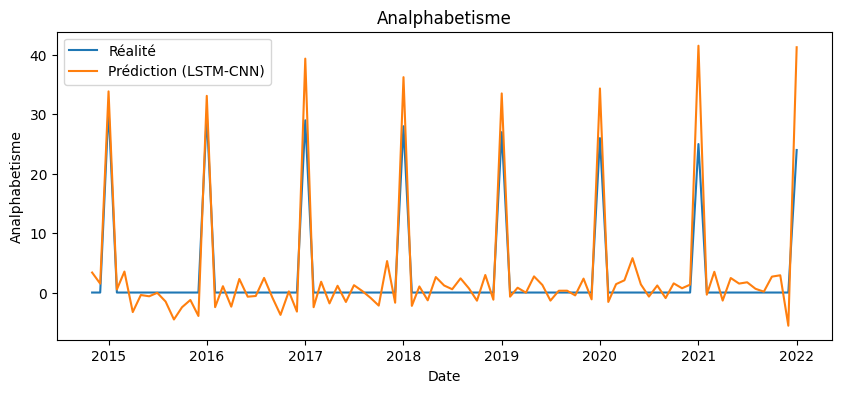

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


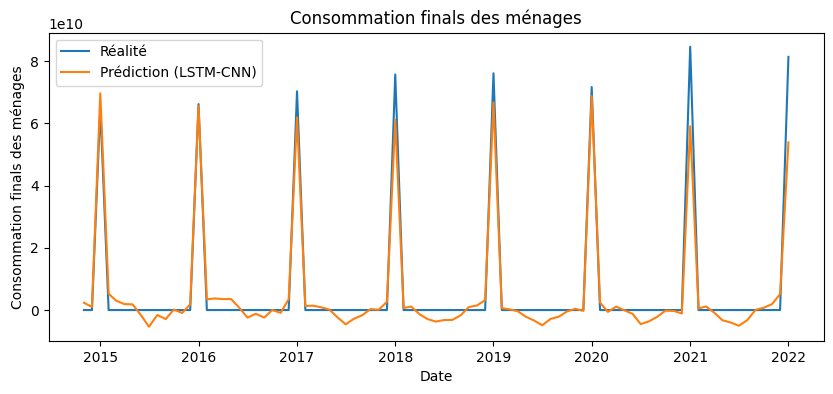

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


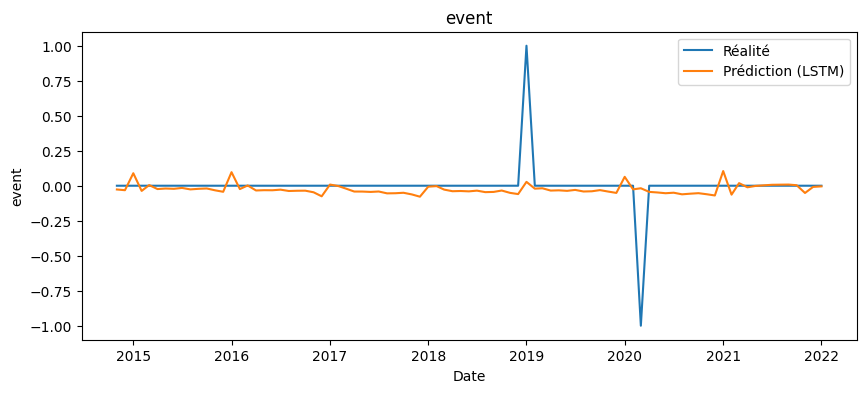

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


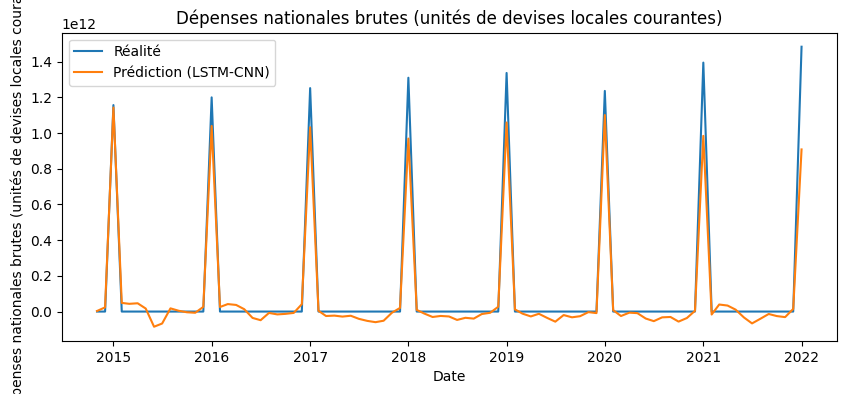

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


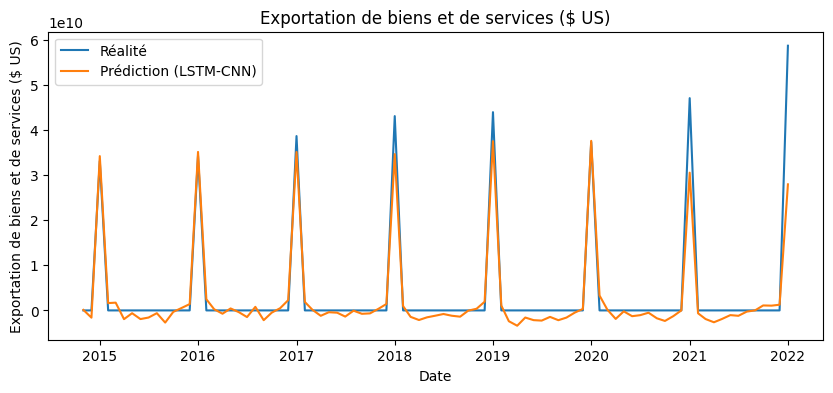

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


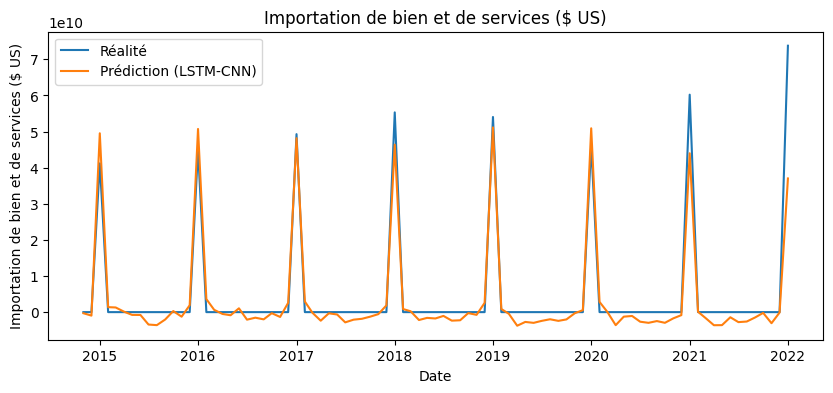

In [25]:
# Cell 13: Visualisation des prédictions pour chaque indicateur

# Utiliser tout l’index de test_df, pas à partir de 30
dates = test_df.index

# y_true calculé en Cell 12 (shape == len(dates) x n_features)
# On le reconstruit au besoin :
target_dims = len(num_cols)
mins   = scaler.min_[:target_dims]
scales = scaler.scale_[:target_dims]
y_true = (y_test - mins) / scales

for i, col in enumerate(num_cols):
    # prédictions du meilleur modèle pour cette colonne
    m = final_models[best_model_per_col[col]]
    preds_scaled = m.predict(X_test)[:, i]
    preds = (preds_scaled - mins[i]) / scales[i]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, y_true[:, i], label='Réalité')
    plt.plot(dates, preds,     label=f'Prédiction ({best_model_per_col[col]})')
    plt.title(col)
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()
